In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Mutual Information for classification
from sklearn.feature_selection import mutual_info_classif

In [3]:
SEED = 78
VAL_SPLIT = 0.9

In [4]:
test_csv = pd.read_csv("data/test.csv")
train_csv = pd.read_csv("data/train.csv")

# Data Exploration

In [5]:
train_csv.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
test_csv.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [7]:
train_csv.info()
print("-"*50)
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (tot

We have mostly non-null data, so no need to remove any columns on that basis.

Splitting up PassengerId values (x_y) into x and y might be worthwhile.

Splitting up Cabin values (x/y/z) int x, y, and z might be worthwhile.

Splitting up Name values (x y) into x and y might be worthwhile.

In [8]:
# Split passenger Id
train_csv = train_csv.join(
    train_csv["PassengerId"].str.split("_", expand=True)
).rename(
    columns={0: "Id_1", 1: "Id_2"}
).set_index('PassengerId')

test_csv = test_csv.join(
    test_csv["PassengerId"].str.split("_", expand=True)
).rename(
    columns={0: "Id_1", 1: "Id_2"}
).set_index('PassengerId')


# Split Cabin
train_csv = train_csv.join(
    train_csv["Cabin"].str.split("/", expand=True)
).rename(
    columns={0 : "Cabin_deck", 1: "Cabin_num", 2 : "Cabin_side"}
).drop("Cabin", axis=1)

test_csv = test_csv.join(
    test_csv["Cabin"].str.split("/", expand=True)
).rename(
    columns={0 : "Cabin_deck", 1: "Cabin_num", 2 : "Cabin_side"}
).drop("Cabin", axis=1)


# Split Name
train_csv = train_csv.join(
    train_csv["Name"].str.split(" ", expand=True)
).rename(
    columns={0: "Name_First", 1: "Name_Last"}
).drop("Name", axis=1)

test_csv = test_csv.join(
    test_csv["Name"].str.split(" ", expand=True)
).rename(
    columns={0: "Name_First", 1: "Name_Last"}
).drop("Name", axis=1)

In [9]:
train_csv["Id_1"].value_counts()

8796    8
8168    8
5133    8
5756    8
8988    8
       ..
8019    1
5103    1
5934    1
9101    1
4043    1
Name: Id_1, Length: 6217, dtype: int64

In [10]:
# Most Id_1 values are unique so delete
test_csv.drop("Id_1", axis=1, inplace=True)
train_csv.drop("Id_1", axis=1, inplace=True)

In [11]:
train_csv['Cabin_deck'].unique().tolist(), train_csv['Cabin_num'].unique().tolist(), train_csv['Cabin_side'].unique().tolist()

(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'],
 ['0',
  '1',
  '2',
  '3',
  nan,
  '4',
  '5',
  '6',
  '8',
  '9',
  '10',
  '11',
  '7',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '20',
  '19',
  '23',
  '24',
  '21',
  '25',
  '27',
  '22',
  '29',
  '30',
  '31',
  '26',
  '32',
  '28',
  '37',
  '35',
  '38',
  '36',
  '41',
  '42',
  '33',
  '34',
  '44',
  '45',
  '46',
  '40',
  '47',
  '48',
  '43',
  '50',
  '52',
  '53',
  '54',
  '49',
  '56',
  '51',
  '59',
  '61',
  '63',
  '64',
  '65',
  '55',
  '67',
  '60',
  '68',
  '72',
  '73',
  '62',
  '74',
  '57',
  '76',
  '78',
  '66',
  '82',
  '83',
  '84',
  '85',
  '69',
  '89',
  '90',
  '71',
  '91',
  '92',
  '96',
  '75',
  '97',
  '77',
  '79',
  '98',
  '99',
  '80',
  '81',
  '100',
  '101',
  '86',
  '87',
  '103',
  '70',
  '88',
  '109',
  '93',
  '110',
  '95',
  '111',
  '102',
  '114',
  '115',
  '116',
  '105',
  '117',
  '107',
  '108',
  '118',
  '120',
  '121',
  '39',
  '123',
  '124',


In [12]:
# Cabin_num has a lot of unique discrete values so delete
test_csv.drop("Cabin_num", axis=1, inplace=True)
train_csv.drop("Cabin_num", axis=1, inplace=True)

In [13]:
train_csv['Name_First'].unique().tolist(), train_csv['Name_Last'].unique().tolist()

(['Maham',
  'Juanna',
  'Altark',
  'Solam',
  'Willy',
  'Sandie',
  'Billex',
  'Candra',
  'Andona',
  'Erraiam',
  'Altardr',
  'Wezena',
  'Berers',
  'Reney',
  'Elle',
  'Justie',
  'Flats',
  'Carry',
  'Alus',
  'Lyde',
  'Philda',
  'Almary',
  'Glendy',
  'Mollen',
  'Breney',
  'Mael',
  'Terta',
  nan,
  'Penton',
  'Karard',
  'Anyoni',
  'Ceros',
  'Ginia',
  'Coobix',
  'Cinets',
  'Dontch',
  'Ziba',
  'Luse',
  'Marina',
  'Loise',
  'Jorgie',
  'Margia',
  'Ankalik',
  'Jodye',
  'Kayne',
  'Cassa',
  'Zelowl',
  'Mass',
  'Sony',
  'Vivia',
  'Elaney',
  'Elson',
  'Okulas',
  'Instab',
  'Zinoces',
  'Warry',
  'Shanya',
  'Sterry',
  'Colatz',
  'Diandy',
  'Ninaha',
  'Celine',
  'Velyne',
  'Cinst',
  'Meremy',
  'Nelly',
  'Thell',
  'Gorn',
  'Aldibah',
  'Conk',
  'Pon',
  'Spuri',
  'Dellie',
  'Totse',
  'Eaturs',
  'Coren',
  'Furudah',
  'Stmeal',
  'Heremy',
  'Deanne',
  'Tinez',
  'Gracy',
  'Stald',
  'Tiney',
  'Alchium',
  'Doria',
  'Leence',
  'A

In [14]:
# First and Last Names have too many discrete values so delete
# TODO: do something with last name and family members? maybe???
test_csv.drop("Name_First", axis=1, inplace=True)
train_csv.drop("Name_First", axis=1, inplace=True)

test_csv.drop("Name_Last", axis=1, inplace=True)
train_csv.drop("Name_Last", axis=1, inplace=True)

In [15]:
train_csv.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id_2,Cabin_deck,Cabin_side
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,01,B,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,01,F,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,01,A,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,02,A,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,01,F,S


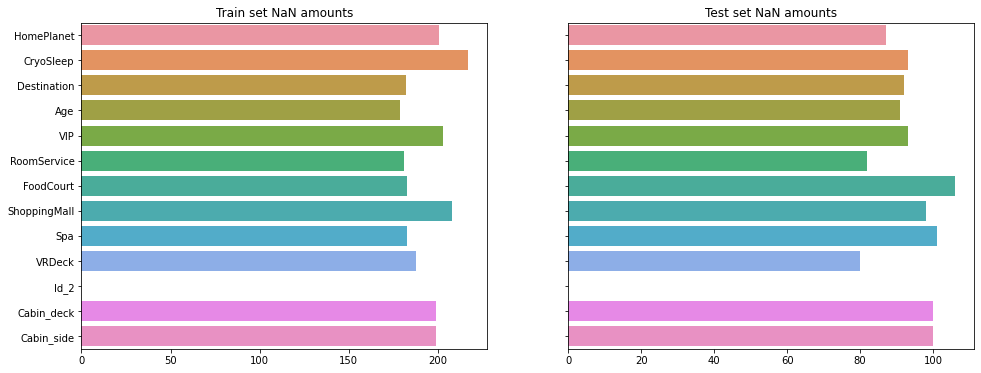

In [16]:
# Check NaN amounts
fig, axs = plt.subplots(1, 2)
nans = train_csv.isna().sum().drop('Transported')
sns.barplot(y=nans.index, x=nans.values, orient='h', ax=axs[0]).set(title="Train set NaN amounts")

nans = test_csv.isna().sum()
sns.barplot(y=nans.index, x=nans.values, orient='h', ax=axs[1]).set(title="Test set NaN amounts", yticklabels=[])
fig.set_size_inches((16, 6))

Observations: 

    We only have full Names (x a) or NaN-s, 
    We only have full Cabin names (x/y/z) or NaN-s,
    NaN amounts are almost equal in all columns (might be because some rows are entirely NaN-s?)

In [17]:
# Check if we have rows where entire rows are NaN (none are found)
test_csv.drop('Id_2', axis=1).isna().all().sum(), train_csv.drop('Id_2', axis=1).isna().all().sum()

(0, 0)

# Looking at the data

In [18]:
# Combine datasets and add TotalSpent column
combined = pd.concat([train_csv.drop('Transported', axis=1), test_csv]).copy()
combined.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id_2,Cabin_deck,Cabin_side
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,01,B,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,01,F,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,01,A,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,02,A,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,01,F,S


## Looking at RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Age

In [19]:
combined[["FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]].isna().any(axis=1).sum()

1363

We have 1363 nan rows in those columns, lets look at their at distributions based on different factors and fill their nans on these factors.

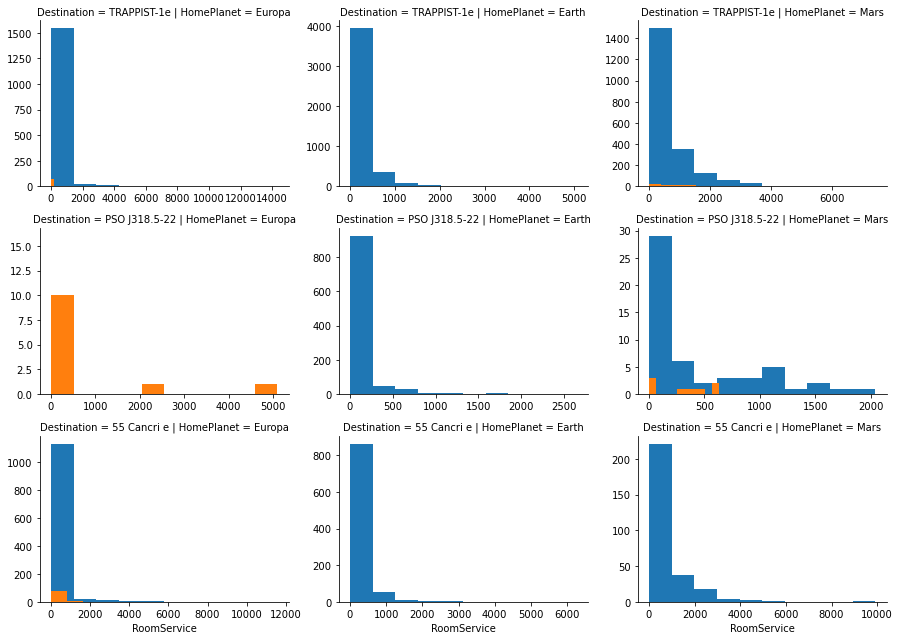

In [20]:
# Relations between HomePlanet, Destination, VIP and RoomService
sns.FacetGrid(data=combined, col='HomePlanet', row='Destination', hue='VIP', sharey=False, sharex=False, aspect=1.4).map(plt.hist, 'RoomService')

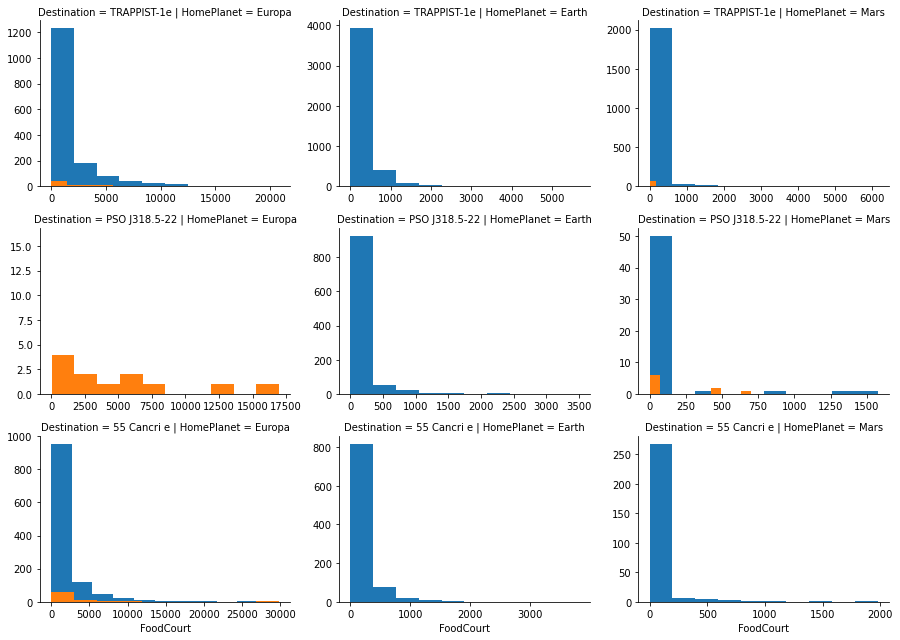

In [21]:
# Relations between HomePlanet, Destination, VIP and FoodCourt
sns.FacetGrid(data=combined, col='HomePlanet', row='Destination', hue='VIP', sharey=False, sharex=False, aspect=1.4).map(plt.hist, 'FoodCourt')

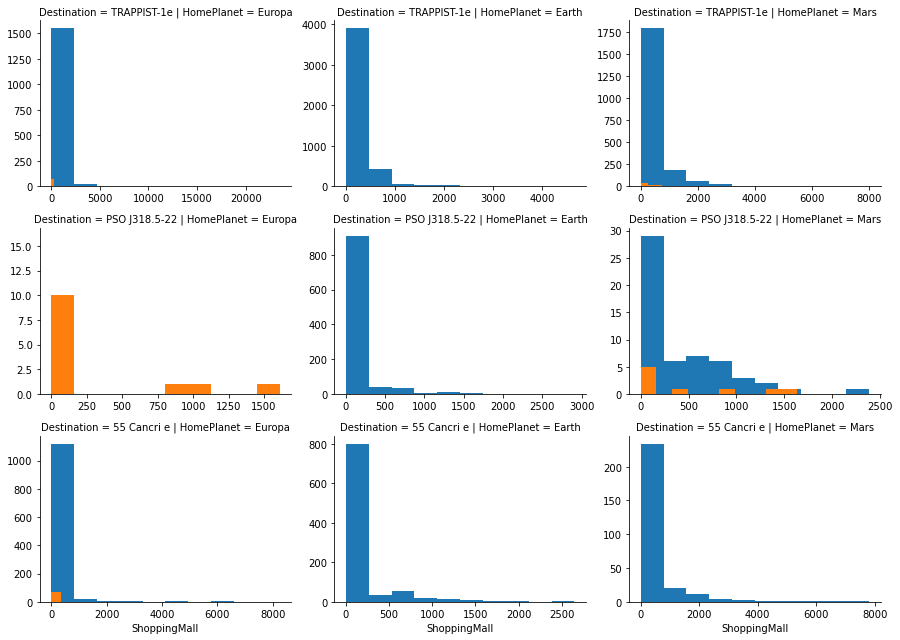

In [22]:
# Relations between HomePlanet, Destination, VIP and ShoppingMall
sns.FacetGrid(data=combined, col='HomePlanet', row='Destination', hue='VIP', sharey=False, sharex=False, aspect=1.4).map(plt.hist, 'ShoppingMall')

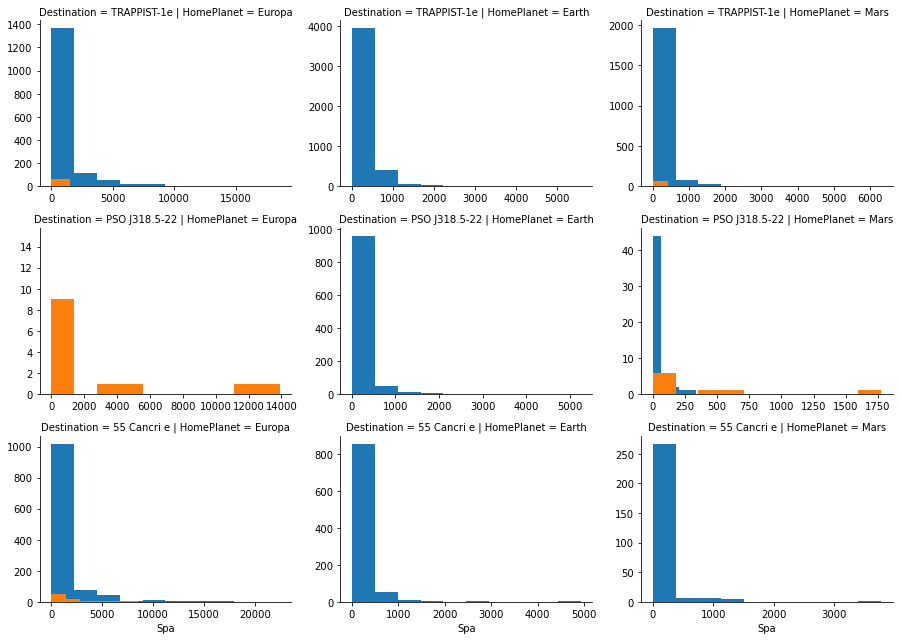

In [23]:
# Relations between HomePlanet, Destination, VIP and Spa
sns.FacetGrid(data=combined, col='HomePlanet', row='Destination', hue='VIP', sharey=False, sharex=False, aspect=1.4).map(plt.hist, 'Spa')

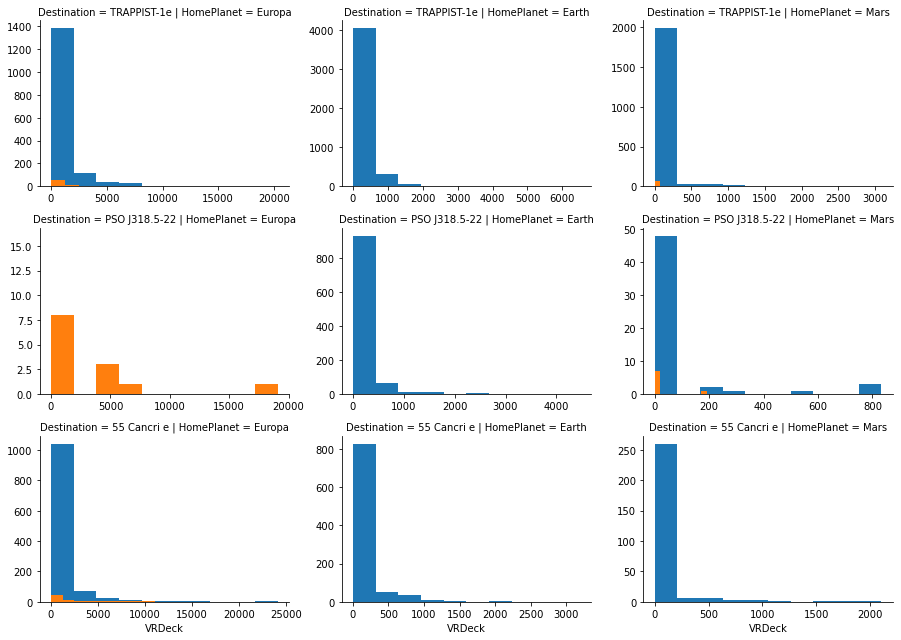

In [24]:
# Relations between HomePlanet, Destination, VIP and VRDeck
sns.FacetGrid(data=combined, col='HomePlanet', row='Destination', hue='VIP', sharey=False, sharex=False, aspect=1.4).map(plt.hist, 'VRDeck')

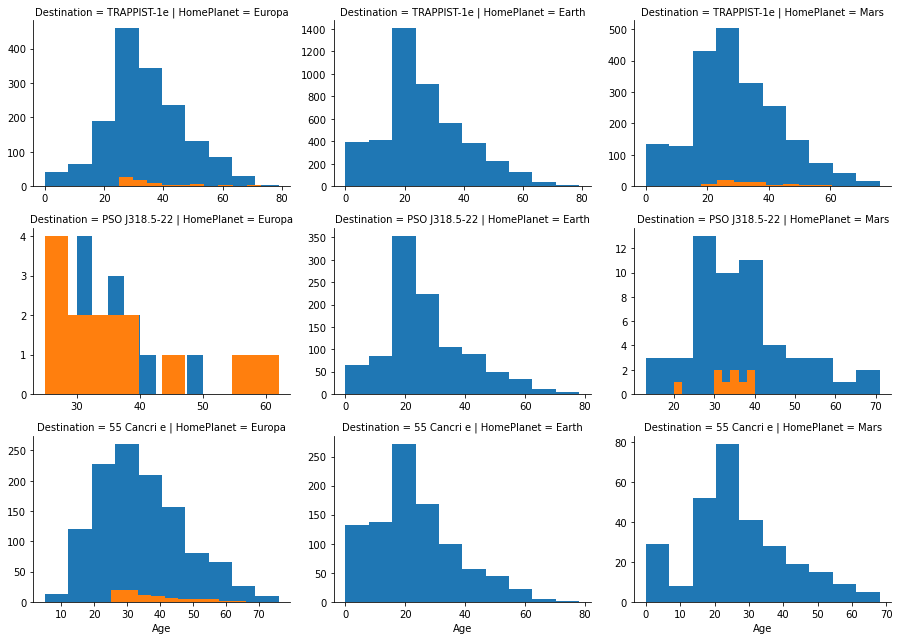

In [25]:
# Relations between HomePlanet, Destination, VIP and Age
sns.FacetGrid(data=combined, col='HomePlanet', row='Destination', hue='VIP', sharey=False, sharex=False, aspect=1.4).map(plt.hist, 'Age')

Observations:

    RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Age have different distributions based on HomePlanet, Destination, VIP status.

In [26]:
tmp = combined.copy()
tmp[["HomePlanet", "Destination", "VIP"]] = tmp[["HomePlanet", "Destination", "VIP"]].fillna("-1")
tmp.groupby(by=["HomePlanet", "Destination", "VIP"]).agg({
    "FoodCourt": "mean", 
    "RoomService": "mean", 
    "Spa": "mean", 
    "VRDeck": "mean",
    "ShoppingMall": "mean"
    })

FoodCourt  RoomService          Spa  \
HomePlanet Destination   VIP                                            
-1         -1            False   698.400000   226.600000    21.000000   
                         -1        0.000000     1.000000     7.000000   
           55 Cancri e   False   753.959184   166.489796   646.102041   
                         True   1474.500000     0.000000     1.000000   
                         -1     1208.000000    28.000000   207.000000   
           PSO J318.5-22 False    56.700000   103.363636    14.727273   
                         -1       46.000000     2.000000   483.000000   
           TRAPPIST-1e   False   219.676617   204.812183   216.128866   
                         True      1.750000  1206.250000     0.000000   
Earth      -1            False   153.678832   179.028986   131.335766   
                         -1      128.600000   238.400000   279.000000   
           55 Cancri e   False   122.425966   141.219017   114.365880   
                         -1      224.214286    70.230769   162.148148   
           PSO J318.5-22 False    89.877953    73.898921    86.914873   
                         -1      147.181818    53.545455   251.045455   
           TRAPPIST-1e   False   161.436478   148.506834   158.732155   
                         -1      103.223301   147.059406   156.699029   
Europa     -1            False   912.653846    25.924528   982.301887   
                         True   4013.000000   127.000000  1119.666667   
           55 Cancri e   False  1476.876385   133.740614   852.346220   
                         True   2792.691358   397.469880  1478.617284   
                         -1     3278.193548    61.064516   701.774194   
           PSO J318.5-22 False     0.000000     0.000000     0.000000   
                         True   4816.833333   639.666667  2688.615385   
           TRAPPIST-1e   False  1356.369085   127.827261   790.767823   
                         True   2167.628205    91.480519   944.311688   
                         -1      993.131579   319.634146  1365.731707   
Mars       -1            False    34.765625   379.375000   183.000000   
                         -1        0.000000    17.000000     3.000000   
           55 Cancri e   False    51.675958   574.708772    90.325175   
                         -1        0.500000   206.000000    74.500000   
           PSO J318.5-22 False    80.407407   424.150943    54.981132   
                         True    188.888889   315.222222   337.444444   
                         -1        0.666667   243.000000   248.000000   
           TRAPPIST-1e   False    49.352827   534.322302   104.086747   
                         True    116.987179   950.316456   213.825000   
                         -1       96.867925   630.096154    89.903846   

                                     VRDeck  ShoppingMall  
HomePlanet Destination   VIP                               
-1         -1            False  2075.200000      0.000000  
                         -1      701.000000    213.000000  
           55 Cancri e   False   636.780000    121.148936  
                         True    327.000000      0.000000  
                         -1        0.000000    973.000000  
           PSO J318.5-22 False   125.681818     59.045455  
                         -1       67.000000      0.000000  
           TRAPPIST-1e   False   272.542714    210.425641  
                         True      0.000000    363.500000  
Earth      -1            False   134.407407    133.716418  
                         -1        4.500000    180.600000  
           55 Cancri e   False   106.828175    125.774920  
                         -1      250.785714     96.250000  
           PSO J318.5-22 False   113.380488     99.686332  
                         -1       51.000000    211.761905  
           TRAPPIST-1e   False   151.544434    142.714702  
                         -1      109.941748    115.554455  
Europa     -1            False   457.538462   

### Filling in missing values

In [27]:
# Fill NaN-s with mean based on group
combined["FoodCourt"]       = tmp.groupby(by=["HomePlanet", "Destination", "VIP"])["FoodCourt"].transform(lambda x: x.fillna(x.mean()))
combined["RoomService"]     = tmp.groupby(by=["HomePlanet", "Destination", "VIP"])["RoomService"].transform(lambda x: x.fillna(x.mean()))
combined["Spa"]             = tmp.groupby(by=["HomePlanet", "Destination", "VIP"])["Spa"].transform(lambda x: x.fillna(x.mean()))
combined["VRDeck"]          = tmp.groupby(by=["HomePlanet", "Destination", "VIP"])["VRDeck"].transform(lambda x: x.fillna(x.mean()))
combined["ShoppingMall"]    = tmp.groupby(by=["HomePlanet", "Destination", "VIP"])["ShoppingMall"].transform(lambda x: x.fillna(x.mean()))
combined["Age"]             = tmp.groupby(by=["HomePlanet", "Destination", "VIP"])["Age"].transform(lambda x: x.fillna(x.mean()))

# Add new TotalSpent column
combined["TotalSpent"] = combined["FoodCourt"] + combined["RoomService"] + combined["Spa"] + combined["VRDeck"] + combined["ShoppingMall"]

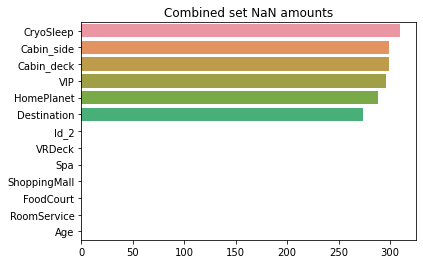

In [28]:
# Check nan counts
nans = combined.isna().sum().drop('TotalSpent').sort_values(ascending=False)
sns.barplot(y=nans.index, x=nans.values, orient='h').set(title="Combined set NaN amounts")
fig.set_size_inches((16, 6))

## VIP column

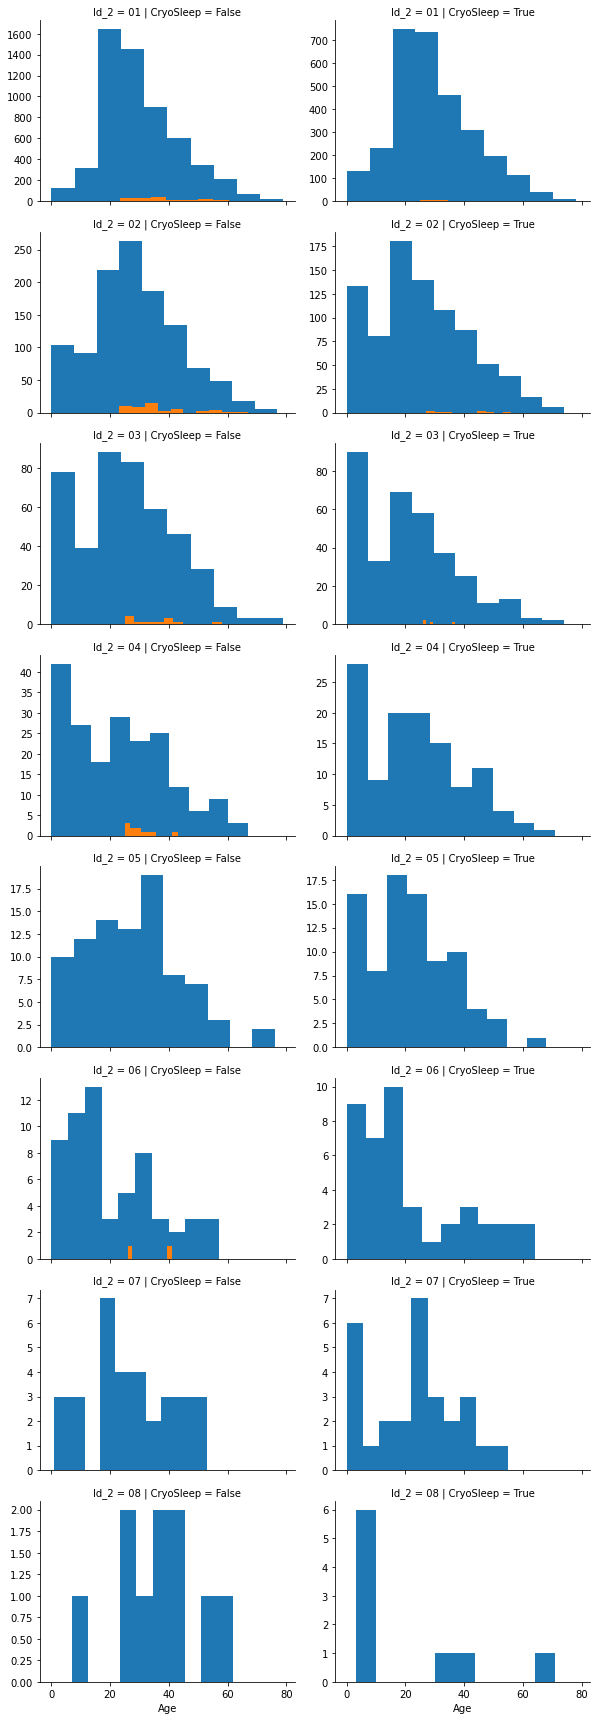

In [29]:
# Relations between CryoSleep, Id_2, VIP and Age
sns.FacetGrid(data=combined, col='CryoSleep', row='Id_2', hue='VIP', sharey=False, aspect=1.4).map(plt.hist, 'Age')

Observations:

    50% of all underage passangers went to CryoSleep,
    Non-VIP 18+ passangers' CryoSleep to non-CryoSleep ratio is almost the same across all ages,
    No underage passangers were VIP,
    Very few VIP-s went to CryoSleep,
    Group 05, 07 and 08 had no VIP-s,
    Group 04 and 06 CryoSleepers had no VIP-s
 
Ideas:

    Bin ages, or divide ages into 18- and 18+,
    Fill missing VIP values based on Group and CryoSleep data,
    Make all underage passangers with missing VIP value non-VIP-s

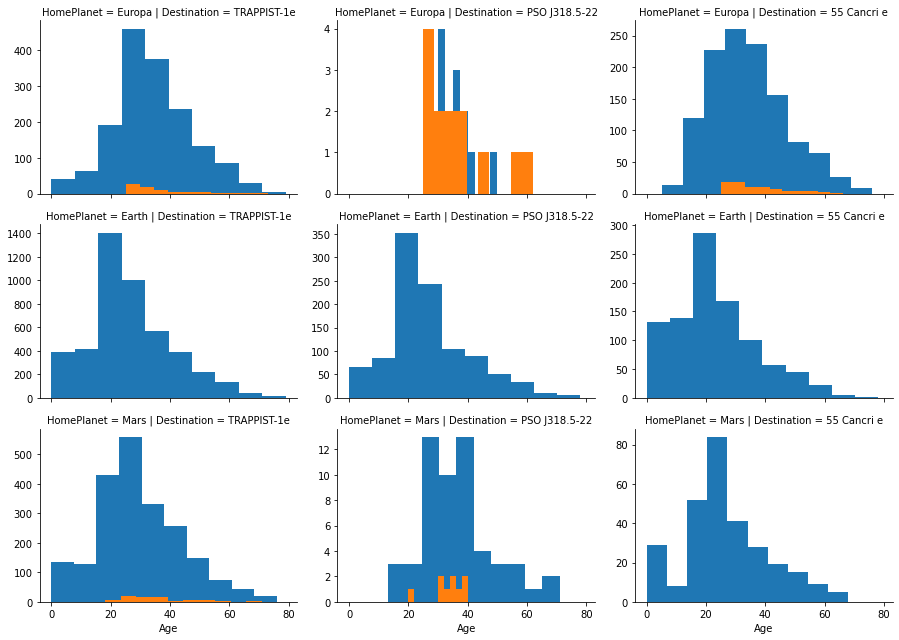

In [30]:
# Relations between HomePlanet, Destination, VIP and Age
sns.FacetGrid(data=combined, row='HomePlanet', col='Destination', hue='VIP', sharey=False, aspect=1.4).map(plt.hist, 'Age')

Observations:

    Europa  ->  PSO                 were most VIP-s,
    Earth   ->  any destination     had no VIP-s,
    Mars    ->  PSO                 had no VIP-s,
    Mars    ->  Cancri              had no VIP-s

Ideas:

    Set missing VIP values to false in (HomePlanet, Destination) pairs where no VIP-s were present.

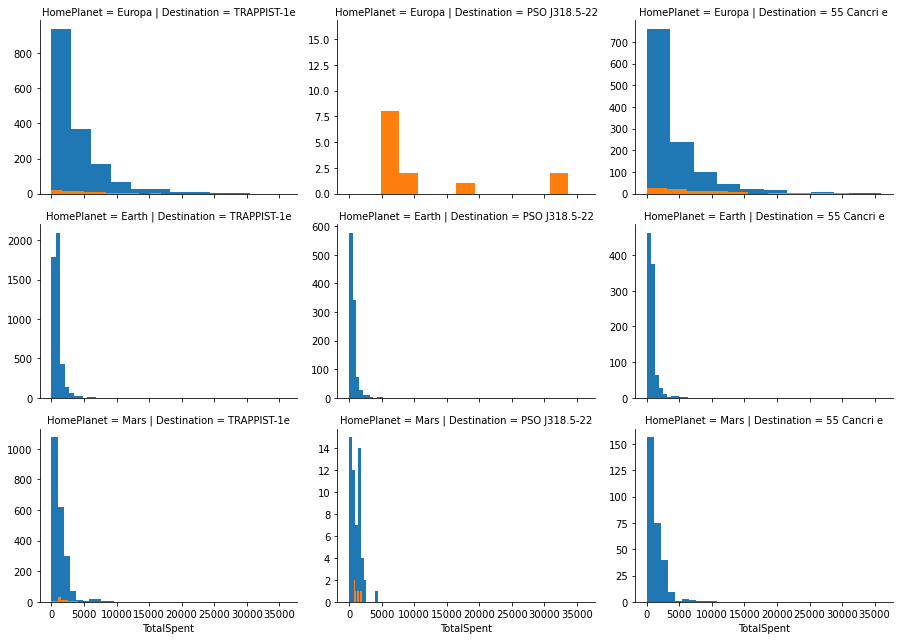

In [31]:
# Relations between HomePlanet, Destination, VIP and TotalSpent
sns.FacetGrid(data=combined, row='HomePlanet', col='Destination', hue='VIP', sharey=False, aspect=1.4).map(plt.hist, 'TotalSpent')

Observations:

    TotalSpent has small if not no correlation to VIP,
    HomePlanet Europa had the biggest spenders

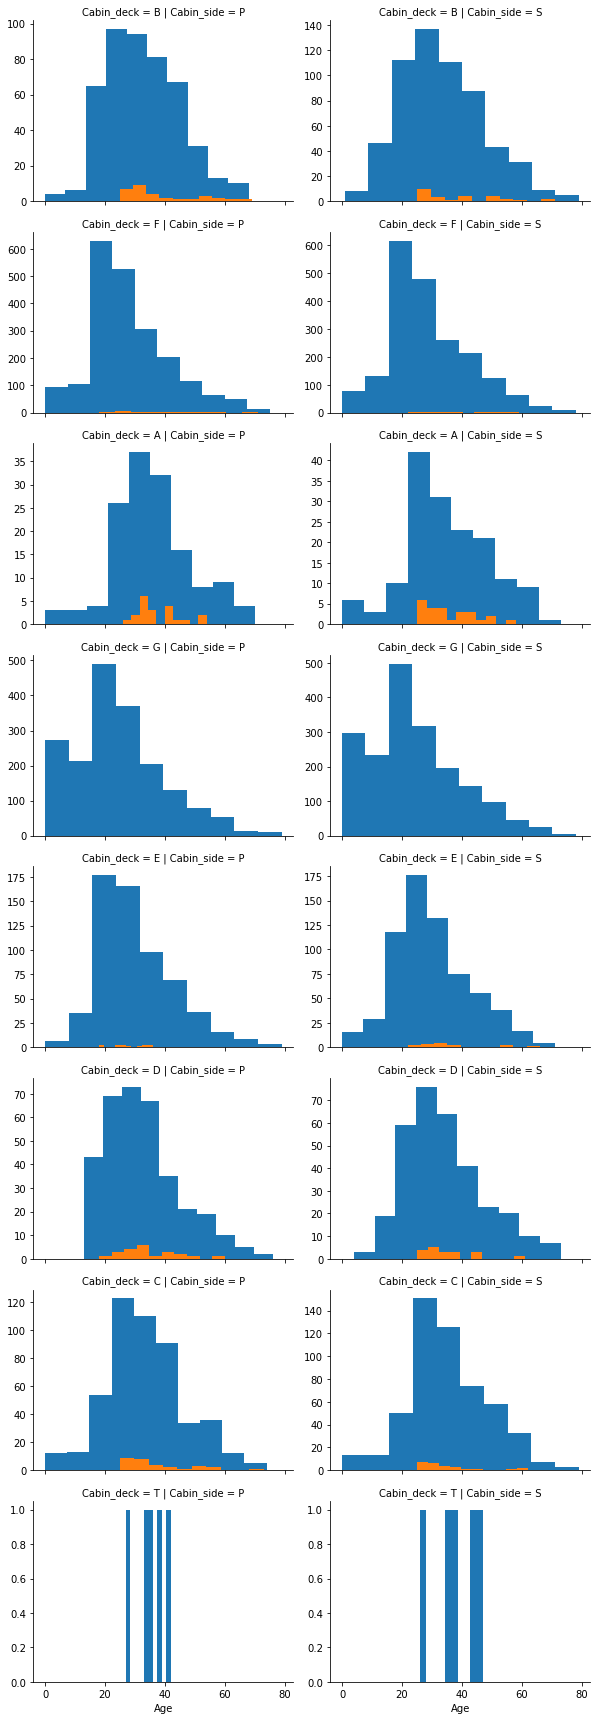

In [32]:
# Relations between Cabin_deck, Cabin_side, VIP and Age
sns.FacetGrid(data=combined, row='Cabin_deck', col='Cabin_side', hue='VIP', sharey=False, aspect=1.4).map(plt.hist, 'Age')

Observations:

    Deck G and T had no VIP-s

### Filling in the missing values

In [33]:
#   Earth   ->  any destination     had no VIP-s,
#   Mars    ->  PSO                 had no VIP-s,
#   Mars    ->  Cancri              had no VIP-s
combined.loc[combined['HomePlanet'] == 'Earth', 'VIP'] = \
    combined.loc[combined['HomePlanet'] == 'Earth', 'VIP'].fillna(value=0)  # 159 rows
combined.loc[(combined['HomePlanet'] == 'Mars') & (combined['Destination'] == 'PSO J318.5-22'), 'VIP'] = \
    combined.loc[(combined['HomePlanet'] == 'Mars') & (combined['Destination'] == 'PSO J318.5-22'), 'VIP'].fillna(value=False) # 3
combined.loc[(combined['HomePlanet'] == 'Mars') & (combined['Destination'] == '55 Cancri e'), 'VIP'] = \
    combined.loc[(combined['HomePlanet'] == 'Mars') & (combined['Destination'] == '55 Cancri e'), 'VIP'].fillna(value=False) # 4


# Group 05, 07 and 08 had no VIP-s,
# Group 04 and 06 CryoSleepers had no VIP-s
combined.loc[combined['Id_2'] == '05', 'VIP'] = \
    combined.loc[combined['Id_2'] == '05', 'VIP'].fillna(value=False) # 1
combined.loc[combined['Id_2'] == '07', 'VIP'] = \
    combined.loc[combined['Id_2'] == '07', 'VIP'].fillna(value=False) # 1
combined.loc[combined['Id_2'] == '08', 'VIP'] = \
    combined.loc[combined['Id_2'] == '08', 'VIP'].fillna(value=False) # 0
combined.loc[(combined['Id_2'] == '04') & (combined['CryoSleep'] == True), 'VIP'] = \
    combined.loc[(combined['Id_2'] == '04') & (combined['CryoSleep'] == True), 'VIP'].fillna(value=False) # 0
combined.loc[(combined['Id_2'] == '06') & (combined['CryoSleep'] == True), 'VIP'] = \
    combined.loc[(combined['Id_2'] == '06') & (combined['CryoSleep'] == True), 'VIP'].fillna(value=False) # 0


# Very few VIP-s went to cryosleep
combined.loc[combined['VIP'] == True, 'CryoSleep'] = \
    combined.loc[combined['VIP'] == True, 'CryoSleep'].fillna(value=False) # 6


# Deck G and T had no VIP-s
combined.loc[combined['Cabin_deck'] == 'G', 'VIP'] = \
    combined.loc[combined['Cabin_deck'] == 'G', 'VIP'].fillna(value=False) # 1
combined.loc[combined['Cabin_deck'] == 'T', 'VIP'] = \
    combined.loc[combined['Cabin_deck'] == 'T', 'VIP'].fillna(value=False) # 1


# Underage passangers were not VIP-s
combined.loc[combined['Age'] <= 18, 'VIP'] = \
    combined.loc[combined['Age'] <= 18, 'VIP'].fillna(value=False) # 10

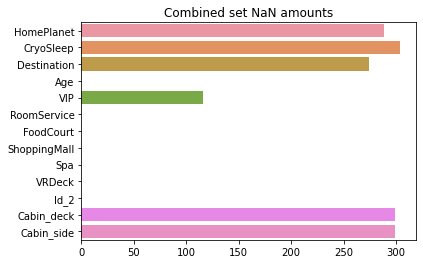

In [34]:
nans = combined.isna().sum().drop('TotalSpent')
sns.barplot(y=nans.index, x=nans.values, orient='h').set(title="Combined set NaN amounts")
fig.set_size_inches((16, 6))

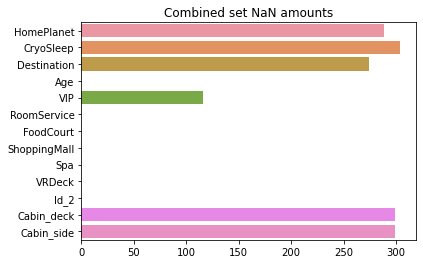

In [35]:
nans = combined.isna().sum().drop('TotalSpent')
sns.barplot(y=nans.index, x=nans.values, orient='h').set(title="Combined set NaN amounts")
fig.set_size_inches((16, 6))

### Final data preparation steps

In [36]:
# Turn categorical columns into one-hot vectors and normalize
combined_final = pd.get_dummies(combined)
numerical_columns = combined_final.select_dtypes('float64').columns
combined_final[numerical_columns] = \
    (combined_final[numerical_columns] - combined_final[numerical_columns].mean()) / combined_final[numerical_columns].std()
combined_final.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpent,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0.717616,-0.347192,-0.287592,-0.299504,-0.275709,-0.261803,-0.520426,0,1,0,...,0,1,0,0,0,0,0,0,1,0
0002_01,-0.335341,-0.177265,-0.281858,-0.256672,0.215002,-0.224157,-0.258673,1,0,0,...,0,0,0,0,0,1,0,0,0,1
0003_01,2.051362,-0.280156,1.990917,-0.299504,5.726344,-0.219880,3.172212,0,1,0,...,1,0,0,0,0,0,0,0,0,1
0003_02,0.296433,-0.347192,0.529893,0.336118,2.699843,-0.096677,1.320381,0,1,0,...,1,0,0,0,0,0,0,0,0,1
0004_01,-0.896918,0.125175,-0.242990,-0.040801,0.229303,-0.260091,-0.132419,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [37]:
# Splitting into train, validation and test data
x_train_val = combined_final.loc[train_csv.index]
y_train_val = train_csv['Transported']
x_test      = combined_final.loc[test_csv.index]

train_size = int(len(x_train_val) * VAL_SPLIT)
x_train = x_train_val[:train_size]
y_train = y_train_val[:train_size]
x_val   = x_train_val[train_size:]
y_val   = y_train_val[train_size:]

x_train_val = np.array(x_train_val)
y_train_val = np.array(y_train_val)
x_test  = np.array(x_test)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val   = np.array(x_val)
y_val   = np.array(y_val)

combined_final.shape, x_train_val.shape, y_train_val.shape, x_test.shape, x_train.shape, x_val.shape

((12970, 35), (8693, 35), (8693,), (4277, 35), (7823, 35), (870, 35))

In [38]:
# See mutual information scores
mi_scores = mutual_info_classif(x_train_val, y_train_val)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=combined_final.columns).sort_values()
mi_scores.sort_values(ascending=False)

TotalSpent                   0.128605
CryoSleep_True               0.113389
CryoSleep_False              0.105271
Spa                          0.080258
RoomService                  0.074667
VRDeck                       0.069169
ShoppingMall                 0.045602
FoodCourt                    0.044700
Cabin_deck_B                 0.014435
HomePlanet_Earth             0.012433
Age                          0.010934
Id_2_01                      0.010536
Cabin_side_P                 0.009606
Destination_55 Cancri e      0.009223
Cabin_deck_T                 0.006848
Cabin_deck_G                 0.006366
Cabin_deck_E                 0.005963
Id_2_03                      0.005388
HomePlanet_Europa            0.004948
Cabin_deck_C                 0.004751
VIP_False                    0.004032
Id_2_04                      0.003953
HomePlanet_Mars              0.003616
Cabin_side_S                 0.003560
VIP_True                     0.003560
Cabin_deck_A                 0.002873
Cabin_deck_D

Text(0.5, 1.0, 'Mutual Information Scores')

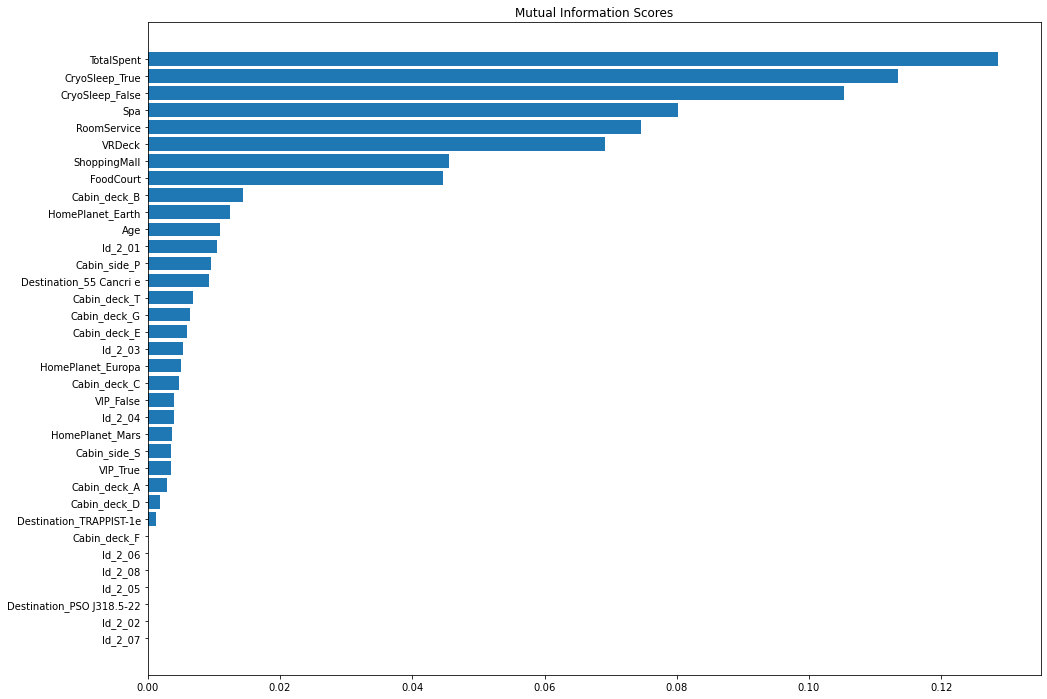

In [39]:
idx = np.arange(len(mi_scores))
plt.figure(figsize=(16, 12))
plt.barh(idx, mi_scores)
plt.yticks(idx, mi_scores.index)
plt.title("Mutual Information Scores")


# Building the model

In [40]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.ensemble import RandomForestClassifier

## Trying out random forest

In [46]:
# Trying out Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
rf.fit(x_train, y_train)

print('Train accuracy: ', rf.score(x_train, y_train))
print('Validation accuracy: ', rf.score(x_val, y_val))
print('Total accuracy: ', rf.score(x_train_val, y_train_val))

Train accuracy:  0.9677872938770292
Validation accuracy:  0.8
Total accuracy:  0.9509950534913149


In [42]:
# Retrain on full data
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
rf.fit(x_train_val, y_train_val)

predictions = rf.predict(x_test)

y_test = pd.DataFrame()
y_test["PassengerId"] = test_csv.index
y_test["Transported"] = predictions
y_test.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [43]:
# Score: 0.78209
y_test.to_csv("Random_Forset_Prediction.csv", index=None, header=True)

## Trying out Gradient Boost

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

In [49]:
gb = GradientBoostingClassifier(random_state=SEED)
gb.fit(x_train, y_train)

print('Train accuracy: ', gb.score(x_train, y_train))
print('Validation accuracy: ', gb.score(x_val, y_val))
print('Total accuracy: ', gb.score(x_train_val, y_train_val))

Train accuracy:  0.8195065831522433
Validation accuracy:  0.7839080459770115
Total accuracy:  0.8159438628781779


In [60]:
# Retrain on full data
gb = GradientBoostingClassifier(random_state=SEED)
gb.fit(x_train_val, y_train_val)

predictions = gb.predict(x_test)

y_test = pd.DataFrame()
y_test["PassengerId"] = test_csv.index
y_test["Transported"] = predictions
y_test.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [61]:
# Score: 0.80102
y_test.to_csv("Gradient_Boost_Prediction.csv", index=None, header=True)

## Trying out XGBoost

In [52]:
import xgboost as xgb

In [66]:
bst = xgb.XGBClassifier(random_state=SEED)
bst.fit(x_train, y_train)

print('Train accuracy: ', bst.score(x_train, y_train))
print('Validation accuracy: ', bst.score(x_val, y_val))
print('Total accuracy: ', bst.score(x_train_val, y_train_val))

C:\Users\Achiqso\anaconda3\envs\python_3_6\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy:  0.8769014444586476
Validation accuracy:  0.7931034482758621
Total accuracy:  0.8685148970435983


In [75]:
# Retrain on full data
bst = xgb.XGBClassifier(random_state=SEED)
bst.fit(x_train_val, y_train_val)

predictions = bst.predict(x_test)

y_test = pd.DataFrame()
y_test["PassengerId"] = test_csv.index
y_test["Transported"] = predictions
y_test.head()

C:\Users\Achiqso\anaconda3\envs\python_3_6\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:21:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [76]:
# Score: 0.80289
y_test.to_csv("XGB_Prediction.csv", index=None, header=True)

XGBoost had the best results